In [56]:
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [58]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation((-90,90), resample=False, expand=False, center=None),
    transforms.ToTensor(),
    transforms.Normalize([0.49139969, 0.48215842, 0.44653093], [0.20220212, 0.19931542, 0.20086347])
])
training_data = CIFAR10('cifar/train', train=True, download=True, transform=transform)
val_data = CIFAR10('cifar/train', train=True, download=True, transform=transform)
test_data = CIFAR10('cifar/test', train=False, download=True, transform=transform)
N = len(training_data)

loader_train = DataLoader(training_data, batch_size=128, shuffle=False, sampler=SubsetRandomSampler(range(0,N-5000)))
loader_val = DataLoader(val_data, batch_size=128, shuffle=False, sampler=SubsetRandomSampler(range(N-5000,N)))
loader_test = DataLoader(test_data, 128)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [59]:
class Resnet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.block1 = self._create_block(n, 16, 16, 1)
        self.block2 = self._create_block(n, 16, 32, 2)
        self.block3 = self._create_block(n, 32, 64, 2)
        self.pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, 10)
    
    def _create_block(self, n, num_input, num_output, stride):
        sub_blocks = [Resblock(num_input, num_output, stride)]
        for l in range(n-1):
            sub_blocks.append(Resblock(num_output, num_output, 1))
        return nn.Sequential(*sub_blocks)
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.pool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [60]:
class Resblock(nn.Module):
    def __init__(self, num_input, num_output, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(num_input, num_output, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_output)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_output, num_output, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_output)
        self.relu2 = nn.ReLU()
        self.identity = IdentityMapping(stride, num_input, num_output)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out += self.identity(x)
        return out

In [61]:
#Option A from paper, allows to change size of input image, if necessary (size/2 when stride=2)
#This helps to match sizes of input resblock and output of resblock
class IdentityMapping(nn.Module):
    def __init__(self, stride, num_input, num_output):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=1, stride=stride)
        self.extra_filters = num_output - num_input
        
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.extra_filters))
        out = self.maxpool(out)
        return out

In [62]:
def get_accuracy(model, loader):
    acc = 0.0
    counter = 0
    for idx, (data, labels) in enumerate(loader):
        with torch.no_grad():
            x = data.to(device)
            y = labels.to(device)
            scores = model(x)
            guesses = scores.argmax(dim=1) == y
            acc += guesses.sum().float()/len(guesses)
            counter += 1
    return float(acc / float(counter))

In [65]:
model = Resnet(27)
model.to(device)

Resnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (block1): Sequential(
    (0): Resblock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (identity): IdentityMapping(
        (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Resblock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): C

In [63]:
model = torch.load('./resnet_trained_epoch9.pt')
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [66]:

epochs=100
history = {
    'train_acc': [],
    'val_acc': [],
    'loss': []
}
lr=0.1
for e in range(epochs):
    for idx, (data, labels) in enumerate(loader_train):
        data = data.to(device)
        labels = labels.to(device)
        scores = model(data)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        loss = F.cross_entropy(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 50==0:
            guesses = scores.argmax(dim=1)==labels
            train_acc = float(guesses.sum().float()/len(guesses))
            history['train_acc'].append(train_acc)
            history['loss'].append(float(loss))
            print('Epoch: ', e, 'iteration:', idx)
            print('loss:', float(loss))
            print('train acc:', train_acc)
            val_acc = get_accuracy(model, loader_val)
            history['val_acc'].append(val_acc)
            print('validation acc:', val_acc)
            print('----------------------------------------------------')
    torch.save(model.state_dict(), './resnet_trained_epoch' + str(e)+'.pt')

Epoch:  0 iteration: 0
loss: 9.512516975402832
train acc: 0.1328125
validation acc: 0.1005859375
----------------------------------------------------
Epoch:  0 iteration: 50
loss: 3.5953285694122314
train acc: 0.078125
validation acc: 0.14511719346046448
----------------------------------------------------
Epoch:  0 iteration: 100
loss: 2.588252544403076
train acc: 0.15625
validation acc: 0.14863280951976776
----------------------------------------------------
Epoch:  0 iteration: 150
loss: 2.3237669467926025
train acc: 0.15625
validation acc: 0.18320313096046448
----------------------------------------------------
Epoch:  0 iteration: 200
loss: 2.124213695526123
train acc: 0.171875
validation acc: 0.15175782144069672
----------------------------------------------------
Epoch:  0 iteration: 250
loss: 2.0686521530151367
train acc: 0.1640625
validation acc: 0.19082032144069672
----------------------------------------------------
Epoch:  0 iteration: 300
loss: 2.0078883171081543
train acc

train acc: 0.4140625
validation acc: 0.46953126788139343
----------------------------------------------------
Epoch:  6 iteration: 250
loss: 1.6367298364639282
train acc: 0.46875
validation acc: 0.455078125
----------------------------------------------------
Epoch:  6 iteration: 300
loss: 1.4640247821807861
train acc: 0.453125
validation acc: 0.478515625
----------------------------------------------------
Epoch:  6 iteration: 350
loss: 1.5062099695205688
train acc: 0.375
validation acc: 0.48222658038139343
----------------------------------------------------
Epoch:  7 iteration: 0
loss: 1.3748044967651367
train acc: 0.5078125
validation acc: 0.48613283038139343
----------------------------------------------------
Epoch:  7 iteration: 50
loss: 1.4895707368850708
train acc: 0.4296875
validation acc: 0.4634765684604645
----------------------------------------------------
Epoch:  7 iteration: 100
loss: 1.4951852560043335
train acc: 0.4453125
validation acc: 0.45878908038139343
----------

----------------------------------------------------
Epoch:  13 iteration: 50
loss: 1.0923824310302734
train acc: 0.5703125
validation acc: 0.614062488079071
----------------------------------------------------
Epoch:  13 iteration: 100
loss: 1.1691540479660034
train acc: 0.578125
validation acc: 0.604296863079071
----------------------------------------------------
Epoch:  13 iteration: 150
loss: 1.316742181777954
train acc: 0.515625
validation acc: 0.6021484732627869
----------------------------------------------------
Epoch:  13 iteration: 200
loss: 1.0634000301361084
train acc: 0.6171875
validation acc: 0.604296863079071
----------------------------------------------------
Epoch:  13 iteration: 250
loss: 1.0507256984710693
train acc: 0.625
validation acc: 0.6107422113418579
----------------------------------------------------
Epoch:  13 iteration: 300
loss: 1.047385573387146
train acc: 0.578125
validation acc: 0.581835925579071
----------------------------------------------------
E

----------------------------------------------------
Epoch:  19 iteration: 250
loss: 1.0487136840820312
train acc: 0.6953125
validation acc: 0.6767578125
----------------------------------------------------
Epoch:  19 iteration: 300
loss: 0.8625375628471375
train acc: 0.7109375
validation acc: 0.6669921875
----------------------------------------------------
Epoch:  19 iteration: 350
loss: 0.8305944800376892
train acc: 0.6875
validation acc: 0.687304675579071
----------------------------------------------------
Epoch:  20 iteration: 0
loss: 1.0324841737747192
train acc: 0.6484375
validation acc: 0.650390625
----------------------------------------------------
Epoch:  20 iteration: 50
loss: 1.0089970827102661
train acc: 0.640625
validation acc: 0.675000011920929
----------------------------------------------------
Epoch:  20 iteration: 100
loss: 0.7560073733329773
train acc: 0.765625
validation acc: 0.6787109375
----------------------------------------------------
Epoch:  20 iteration: 

----------------------------------------------------
Epoch:  26 iteration: 50
loss: 0.7798352241516113
train acc: 0.7109375
validation acc: 0.7162109613418579
----------------------------------------------------
Epoch:  26 iteration: 100
loss: 0.6712327599525452
train acc: 0.78125
validation acc: 0.716015636920929
----------------------------------------------------
Epoch:  26 iteration: 150
loss: 0.7984821200370789
train acc: 0.734375
validation acc: 0.7144531607627869
----------------------------------------------------
Epoch:  26 iteration: 200
loss: 0.7322183847427368
train acc: 0.7578125
validation acc: 0.711132824420929
----------------------------------------------------
Epoch:  26 iteration: 250
loss: 0.7414119243621826
train acc: 0.7578125
validation acc: 0.7250000238418579
----------------------------------------------------
Epoch:  26 iteration: 300
loss: 0.81231290102005
train acc: 0.703125
validation acc: 0.725390613079071
--------------------------------------------------

Epoch:  32 iteration: 250
loss: 0.8058611750602722
train acc: 0.7578125
validation acc: 0.725781261920929
----------------------------------------------------
Epoch:  32 iteration: 300
loss: 0.765157163143158
train acc: 0.7890625
validation acc: 0.7447265982627869
----------------------------------------------------
Epoch:  32 iteration: 350
loss: 0.8522114157676697
train acc: 0.6796875
validation acc: 0.7320312857627869
----------------------------------------------------
Epoch:  33 iteration: 0
loss: 0.9641567468643188
train acc: 0.6953125
validation acc: 0.732617199420929
----------------------------------------------------
Epoch:  33 iteration: 50
loss: 0.588024914264679
train acc: 0.8359375
validation acc: 0.734179675579071
----------------------------------------------------
Epoch:  33 iteration: 100
loss: 0.5693071484565735
train acc: 0.796875
validation acc: 0.7337890863418579
----------------------------------------------------
Epoch:  33 iteration: 150
loss: 0.575203716754913

loss: 0.47491970658302307
train acc: 0.828125
validation acc: 0.762890636920929
----------------------------------------------------
Epoch:  39 iteration: 100
loss: 0.5028629302978516
train acc: 0.78125
validation acc: 0.7445312738418579
----------------------------------------------------
Epoch:  39 iteration: 150
loss: 0.6893866658210754
train acc: 0.765625
validation acc: 0.768750011920929
----------------------------------------------------
Epoch:  39 iteration: 200
loss: 0.7332283854484558
train acc: 0.734375
validation acc: 0.753125011920929
----------------------------------------------------
Epoch:  39 iteration: 250
loss: 0.7849578261375427
train acc: 0.734375
validation acc: 0.7601562738418579
----------------------------------------------------
Epoch:  39 iteration: 300
loss: 0.5612252950668335
train acc: 0.8046875
validation acc: 0.7666015625
----------------------------------------------------
Epoch:  39 iteration: 350
loss: 0.6435555815696716
train acc: 0.78125
validation

train acc: 0.8515625
validation acc: 0.7789062857627869
----------------------------------------------------
Epoch:  45 iteration: 300
loss: 0.6120599508285522
train acc: 0.78125
validation acc: 0.7808594107627869
----------------------------------------------------
Epoch:  45 iteration: 350
loss: 0.5817289352416992
train acc: 0.796875
validation acc: 0.782031238079071
----------------------------------------------------
Epoch:  46 iteration: 0
loss: 0.7011871933937073
train acc: 0.7421875
validation acc: 0.7826172113418579
----------------------------------------------------
Epoch:  46 iteration: 50
loss: 0.4633602201938629
train acc: 0.8125
validation acc: 0.774218738079071
----------------------------------------------------
Epoch:  46 iteration: 100
loss: 0.7130950093269348
train acc: 0.7734375
validation acc: 0.7642578482627869
----------------------------------------------------
Epoch:  46 iteration: 150
loss: 0.6249428391456604
train acc: 0.796875
validation acc: 0.7681640982627

validation acc: 0.7816406488418579
----------------------------------------------------
Epoch:  52 iteration: 100
loss: 0.5369389057159424
train acc: 0.8046875
validation acc: 0.7964844107627869
----------------------------------------------------
Epoch:  52 iteration: 150
loss: 0.429678350687027
train acc: 0.8203125
validation acc: 0.787890613079071
----------------------------------------------------
Epoch:  52 iteration: 200
loss: 0.40856578946113586
train acc: 0.859375
validation acc: 0.7789062857627869
----------------------------------------------------
Epoch:  52 iteration: 250
loss: 0.8150941729545593
train acc: 0.7421875
validation acc: 0.7652344107627869
----------------------------------------------------
Epoch:  52 iteration: 300
loss: 0.4355126619338989
train acc: 0.828125
validation acc: 0.7806640863418579
----------------------------------------------------
Epoch:  52 iteration: 350
loss: 0.733543336391449
train acc: 0.7578125
validation acc: 0.7679687738418579
---------

validation acc: 0.780468761920929
----------------------------------------------------
Epoch:  58 iteration: 300
loss: 0.5971633791923523
train acc: 0.828125
validation acc: 0.79296875
----------------------------------------------------
Epoch:  58 iteration: 350
loss: 0.5180978178977966
train acc: 0.8046875
validation acc: 0.7845703363418579
----------------------------------------------------
Epoch:  59 iteration: 0
loss: 0.517901599407196
train acc: 0.8203125
validation acc: 0.779296875
----------------------------------------------------
Epoch:  59 iteration: 50
loss: 0.527533769607544
train acc: 0.828125
validation acc: 0.7857422232627869
----------------------------------------------------
Epoch:  59 iteration: 100
loss: 0.38252362608909607
train acc: 0.875
validation acc: 0.787890613079071
----------------------------------------------------
Epoch:  59 iteration: 150
loss: 0.5060968995094299
train acc: 0.875
validation acc: 0.8033203482627869
------------------------------------

validation acc: 0.7769531607627869
----------------------------------------------------
Epoch:  65 iteration: 100
loss: 0.41439151763916016
train acc: 0.828125
validation acc: 0.7943359613418579
----------------------------------------------------
Epoch:  65 iteration: 150
loss: 0.28738635778427124
train acc: 0.8984375
validation acc: 0.7867187857627869
----------------------------------------------------
Epoch:  65 iteration: 200
loss: 0.35310888290405273
train acc: 0.8828125
validation acc: 0.802929699420929
----------------------------------------------------
Epoch:  65 iteration: 250
loss: 0.44118428230285645
train acc: 0.859375
validation acc: 0.7900390625
----------------------------------------------------
Epoch:  65 iteration: 300
loss: 0.5216434597969055
train acc: 0.8125
validation acc: 0.7939453125
----------------------------------------------------
Epoch:  65 iteration: 350
loss: 0.6303960680961609
train acc: 0.796875
validation acc: 0.796679675579071
---------------------

train acc: 0.7890625
validation acc: 0.7925781607627869
----------------------------------------------------
Epoch:  71 iteration: 300
loss: 0.39984768629074097
train acc: 0.84375
validation acc: 0.802929699420929
----------------------------------------------------
Epoch:  71 iteration: 350
loss: 0.49601608514785767
train acc: 0.8359375
validation acc: 0.8003906607627869
----------------------------------------------------
Epoch:  72 iteration: 0
loss: 0.376008540391922
train acc: 0.875
validation acc: 0.797656238079071
----------------------------------------------------
Epoch:  72 iteration: 50
loss: 0.39653652906417847
train acc: 0.8671875
validation acc: 0.800585925579071
----------------------------------------------------
Epoch:  72 iteration: 100
loss: 0.43436145782470703
train acc: 0.859375
validation acc: 0.7972656488418579
----------------------------------------------------
Epoch:  72 iteration: 150
loss: 0.37740063667297363
train acc: 0.875
validation acc: 0.80449217557907

validation acc: 0.8140625357627869
----------------------------------------------------
Epoch:  78 iteration: 100
loss: 0.5505014657974243
train acc: 0.7890625
validation acc: 0.805859386920929
----------------------------------------------------
Epoch:  78 iteration: 150
loss: 0.42754098773002625
train acc: 0.84375
validation acc: 0.7994140982627869
----------------------------------------------------
Epoch:  78 iteration: 200
loss: 0.4111228585243225
train acc: 0.859375
validation acc: 0.8138672113418579
----------------------------------------------------
Epoch:  78 iteration: 250
loss: 0.2837368845939636
train acc: 0.8984375
validation acc: 0.812304675579071
----------------------------------------------------
Epoch:  78 iteration: 300
loss: 0.3121536672115326
train acc: 0.8984375
validation acc: 0.8121094107627869
----------------------------------------------------
Epoch:  78 iteration: 350
loss: 0.4817494750022888
train acc: 0.84375
validation acc: 0.7964844107627869
-----------

----------------------------------------------------
Epoch:  84 iteration: 300
loss: 0.3913396894931793
train acc: 0.8515625
validation acc: 0.8109375238418579
----------------------------------------------------
Epoch:  84 iteration: 350
loss: 0.4968794882297516
train acc: 0.8359375
validation acc: 0.817578136920929
----------------------------------------------------
Epoch:  85 iteration: 0
loss: 0.20333744585514069
train acc: 0.9296875
validation acc: 0.808398425579071
----------------------------------------------------
Epoch:  85 iteration: 50
loss: 0.44340091943740845
train acc: 0.8671875
validation acc: 0.807421863079071
----------------------------------------------------
Epoch:  85 iteration: 100
loss: 0.27334725856781006
train acc: 0.8984375
validation acc: 0.8119140863418579
----------------------------------------------------
Epoch:  85 iteration: 150
loss: 0.4783267080783844
train acc: 0.8046875
validation acc: 0.807421863079071
--------------------------------------------

----------------------------------------------------
Epoch:  91 iteration: 100
loss: 0.41393256187438965
train acc: 0.875
validation acc: 0.825390636920929
----------------------------------------------------
Epoch:  91 iteration: 150
loss: 0.38665884733200073
train acc: 0.8671875
validation acc: 0.8130859732627869
----------------------------------------------------
Epoch:  91 iteration: 200
loss: 0.3333037197589874
train acc: 0.9140625
validation acc: 0.814648449420929
----------------------------------------------------
Epoch:  91 iteration: 250
loss: 0.37034016847610474
train acc: 0.8515625
validation acc: 0.822070300579071
----------------------------------------------------
Epoch:  91 iteration: 300
loss: 0.3205554783344269
train acc: 0.8828125
validation acc: 0.8179687857627869
----------------------------------------------------
Epoch:  91 iteration: 350
loss: 0.3300492465496063
train acc: 0.8828125
validation acc: 0.8121094107627869
--------------------------------------------

validation acc: 0.82421875
----------------------------------------------------
Epoch:  97 iteration: 300
loss: 0.38705021142959595
train acc: 0.8515625
validation acc: 0.8208984732627869
----------------------------------------------------
Epoch:  97 iteration: 350
loss: 0.26371821761131287
train acc: 0.90625
validation acc: 0.8125
----------------------------------------------------
Epoch:  98 iteration: 0
loss: 0.4080832302570343
train acc: 0.8828125
validation acc: 0.825976550579071
----------------------------------------------------
Epoch:  98 iteration: 50
loss: 0.33916667103767395
train acc: 0.8828125
validation acc: 0.820507824420929
----------------------------------------------------
Epoch:  98 iteration: 100
loss: 0.4431253671646118
train acc: 0.875
validation acc: 0.814648449420929
----------------------------------------------------
Epoch:  98 iteration: 150
loss: 0.4327128529548645
train acc: 0.859375
validation acc: 0.8148437738418579
-----------------------------------

In [38]:
f = 2000 % 2000
f

0

In [44]:
import matplotlib.pyplot as plt

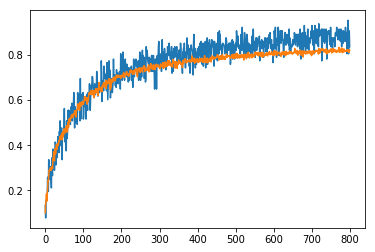

In [67]:
plt.plot(range(len(history['train_acc'])), history['train_acc'])
plt.plot(range(len(history['train_acc'])), history['val_acc'])
plt.show()

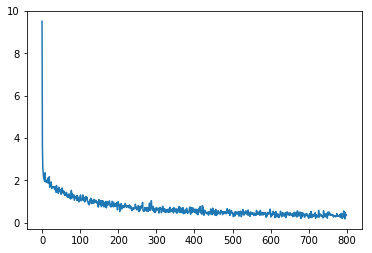

In [68]:
plt.plot(range(len(history['train_acc'])), history['loss'])
